In [131]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tensorflow import keras
import random
from tensorflow import convert_to_tensor as convert
import json
import datetime as dt
from tensorflow.keras.models import *
from tqdm import tqdm 
import tensorflow as tf
tf.__version__
import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Input
path_base = "./"
from IPython.display import Audio
import os

In [132]:
num_iter = 0
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        self.num_iter=0
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.volume_normal = params['volume_normal']
        self.dfs = df
        self.state_dimensions = self.num_stocks*5+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -np.ones(self.num_stocks), high = np.ones(self.num_stocks),dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = [self.state_dimensions], dtype = np.float32)

    def reset(self, intial_balance = 1000000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        self.balance = intial_balance
        self.correct=True
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0.0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,            
            'shares_normal': self.shares_normal,
            'balance_normal': self.balance_normal,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'correct': self.correct
        }
        self.frame, self.info = self.observe()
        print('reset ',self.current_step)
        return self.frame
        
    def get_price(self):
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.max(np.array([df.loc[self.current_step, 'High'] for df in self.dfs]))
        self.highest_price = np.maximum(self.highest_price, high)
    
    def validate(self, action):
        sum = 0
        for i in range(self.num_stocks):
            if action[i] < 0:
                if self.shares_held[0][i] < -action[i]:
                    self.correct=False
                    return False, (self.shares_held[0][i] + action[i])*self.current_price[0][i] 
            sum -= self.broke(self.current_price[0][i]*abs(action[i]))
        
        sum -= np.sum(self.current_price[0]*action)
        if sum + self.balance < 0:
            self.correct=False
            return False, sum+self.balance
        self.correct=True
        print(self.current_step,'yay',sum+self.balance, self.act, action)
        return True, sum

    def observe(self):
        for i in range(self.num_stocks):
            self.frame[4*i:4*i+4] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])/self.highest_price
        self.frame[self.num_stocks*4:self.num_stocks*5] = self.shares_held/self.shares_normal
        self.frame[5*self.num_stocks] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_normal': self.shares_normal,
            'balance_normal': self.balance_normal,
            'shares_held' : self.shares_held,
            'correct': self.correct
        }
        return self.frame, self.info
        
    def broke(self, amount):
        return max(amount * self.brokerage_rate, self.min_brokerage)
    
    def update(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)
    
    def take_action(self, action):
        action *= self.shares_normal
        self.current_price = self.get_price()
        validation = self.validate(action)
        if not validation[0]:
            return validation[1], False
        self.set_high()
        self.balance += validation[1]
        self.shares_held += action
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update(reward)
        return reward, True
            
    def step(self, action):
        self.act = action.copy()
#         self.num_iter+=1;
#         if(self.num_iter%1000==0) and (not self.train):
#             print(self.num_iter)
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros(self.state_dimensions), 0, self.done, self.info
        reward, status = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.1
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : 2,
        'min_brokerage' : 30.0,
        'brokerage_rate' : 0.001,
        'balance_normal' : 1000000,
        'shares_normal' : 100000,
        'volume_normal' : 2147483647,
    }
    return StockEnv(dfs, params, train), min([len(d.loc[:,'Open']) for d in dfs])

In [137]:
from stable_baselines.common.vec_env import DummyVecEnv,VecCheckNan
from stable_baselines.ddpg.policies import MlpPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.ddpg.policies import FeedForwardPolicy
from stable_baselines import DDPG

def mul_state(y,info):
    for i in range(len(files)):
        y[0,4*i:4*i+4] = y[0,4*i:4*i+4]*info['highest_price']
    y[0,-len(files)-1:-1] = y[0,-len(files)-1:-1]*info['shares_normal']
    y[0,-1] = y[0,-1]*info['balance_normal']
    return y


def stable_val(env,agent,ITERATIONS = 1000):
    print('test')
    profit = np.zeros(ITERATIONS)
    r  = np.zeros(ITERATIONS)
    action = np.zeros((ITERATIONS,2))
    shares = np.zeros((ITERATIONS+1,2))
    balance = np.zeros(ITERATIONS+1)
    y = env.reset()
    balance[0] = y[0,-1]
    shares[0,:] = y[0,-len(files)-1:-1]
    for i in range(ITERATIONS):
        y = np.reshape(y,[1,11])
        action[i,:],_ = agent.predict(y)
        y, reward, done, info = env.step(np.reshape(action[i],[1,action[i].shape[0]]))
        info = info[0]
        action[i]*= info['current_price'][0]
        y = mul_state(y,info)
        balance[i+1] += y[0,-1]
        shares[i+1,:] += y[0,-len(files)-1:-1]
        r[i] += reward
        if done:
            print('x',i)
            break        
    for i in range(ITERATIONS-1):
        profit[i+1] += profit[i]
    action[-1]*= info['current_price'][0]
    
    return (profit), (r), shares, balance, action

class CustomDDPGPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomDDPGPolicy, self).__init__(*args, **kwargs, reuse = True,
                                           layers=[512, 256, 128, 64],
                                           layer_norm=False,
                                           feature_extraction="mlp")
        print('Custom')

In [ ]:
files = ['../AAPL.csv','../MSFT.csv']
env, _ = create_stock_env(files,train=True)
env = DummyVecEnv([lambda: env])
n_actions = env.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

model = DDPG(CustomDDPGPolicy, env, verbose=1, param_noise=param_noise, action_noise=action_noise)

N = 5
num = 10

env_test, test_iter = create_stock_env(files,train=False)
profit = np.zeros((num,test_iter))
r  = np.zeros((num,test_iter))
action = np.zeros((num,test_iter,n_actions))
shares = np.zeros((num, test_iter+1,n_actions))
balance = np.zeros((num, test_iter+1))
model.learn(total_timesteps=400000)
model.save("ddpg_baseline")

for j in range(num):
    model.learn(total_timesteps=4000000)
    model.save("ddpg_baseline")
    print('test')
    y = env.reset()
    balance[j,0] = y[0,-1]
    shares[j,0,:] = y[0,-len(files)-1:-1]
    for i in range(test_iter):
        action[j,i,:],_ = model.predict(y)
#        print('before action = ',action[j,i])
        y, reward, done, info = env.step(np.reshape(action[j,i],[1,action[j,i].shape[0]]))
        info = info[0]
#        action[j,i]*= info['current_price'][0]
#        print('after action = ',action[j,i], 'current step',info['current_step'], y)
        y = mul_state(y,info)
        balance[j,i+1] += y[0,-1]
        shares[j,i+1,:] += y[0,-len(files)-1:-1]
        r[j,i] += reward
        if done:
            print('x',i)
            break        
    for i in range(test_iter-1):
        profit[j,i+1] += profit[j,i]
    action[j,-1]*= info['current_price'][0]
    print(profit[j,-1],r[j,-1],action[j,-1],shares[j,-1],balance[j,-1])

Custom
Custom
reset  292
294 yay 425123.57226571837 [0.02770126 0.05664241] [2770.126 5664.241]
307 yay 324318.17684673663 [0.02572405 0.00183475] [2572.4053   183.47502]
317 yay 315463.9060325625 [ 0.0886848  -0.03615677] [ 8868.4795 -3615.6772]
325 yay 174536.78271311452 [0.02875996 0.00516748] [2875.9956  516.7484]
326 yay 610414.1885387272 [-0.08038962 -0.01920664] [-8038.962  -1920.6643]
331 yay 75706.87046796107 [-0.02988523  0.07759893] [-2988.5232  7759.893 ]
333 yay 294692.4895809558 [-0.01913494 -0.01547921] [-1913.4939 -1547.9207]
338 yay 214334.16621987172 [-0.01292473  0.01650238] [-1292.473  1650.238]
339 yay 561491.9306365849 [ 0.00369442 -0.04430407] [  369.4415 -4430.407 ]
373 yay 49285.22652769915 [0.04923546 0.03883851] [4923.5464 3883.8506]
375 yay 469137.6648858369 [-0.04881734 -0.02463824] [-4881.734  -2463.8235]
377 yay 429404.2197281376 [ 0.06042063 -0.03159845] [ 6042.0635 -3159.845 ]
390 yay 196251.97933598535 [ 0.0627296  -0.01354188] [ 6272.9595 -1354.1877]


reset  3957
reset  2065
reset  1655
---------------------------------------
| reference_Q_mean        | -6.45e+07 |
| reference_Q_std         | 4.57e+07  |
| reference_action_mean   | -0.0458   |
| reference_action_std    | 0.568     |
| reference_actor_Q_mean  | -5.88e+07 |
| reference_actor_Q_std   | 4.28e+07  |
| rollout/Q_mean          | -4.12e+07 |
| rollout/actions_mean    | -0.106    |
| rollout/actions_std     | 0.773     |
| rollout/episode_steps   | 2.7e+03   |
| rollout/episodes        | 22        |
| rollout/return          | -1.97e+10 |
| rollout/return_history  | -1.97e+10 |
| total/duration          | 504       |
| total/episodes          | 22        |
| total/epochs            | 1         |
| total/steps             | 59998     |
| total/steps_per_second  | 119       |
| train/loss_actor        | 6.28e+07  |
| train/loss_critic       | 2.3e+13   |
| train/param_noise_di... | 0         |
---------------------------------------

4680 yay 287897.92010288604 [0.01229692 0.0


reset  2135
2435 yay 77263.94672593812 [0.05929267 0.05192029] [5929.2676 5192.0293]
reset  3715
4394 yay 746290.0070414633 [0.00234699 0.03558254] [ 234.69925 3558.2542 ]
4398 yay 105153.94627976837 [ 0.05894196 -0.01924866] [ 5894.196  -1924.8665]
reset  561
2482 yay 673507.9785252353 [0.01449001 0.03620791] [1449.0009 3620.7915]
2638 yay 578566.1720282978 [ 0.00567734 -0.0004276 ] [567.73425  -42.760372]
4536 yay 153469.74897280062 [-0.0035671   0.08506238] [-356.70996 8506.238  ]
4613 yay 429851.9022644536 [ 0.03230846 -0.1085133 ] [  3230.846 -10851.329]
reset  2562
2590 yay 406212.13367593393 [0.02017879 0.13914824] [ 2017.8795 13914.823 ]
---------------------------------------
| reference_Q_mean        | -7.67e+07 |
| reference_Q_std         | 5.46e+07  |
| reference_action_mean   | 0.1       |
| reference_action_std    | 0.627     |
| reference_actor_Q_mean  | -6.84e+07 |
| reference_actor_Q_std   | 5.2e+07   |
| rollout/Q_mean          | -5.19e+07 |
| rollout/actions_mean   

2844 yay 537229.5700139514 [ 0.02745271 -0.21748424] [  2745.2708 -21748.424 ]
---------------------------------------
| reference_Q_mean        | -9.45e+07 |
| reference_Q_std         | 5.62e+07  |
| reference_action_mean   | -0.00636  |
| reference_action_std    | 0.621     |
| reference_actor_Q_mean  | -8.7e+07  |
| reference_actor_Q_std   | 5.48e+07  |
| rollout/Q_mean          | -6.66e+07 |
| rollout/actions_mean    | -0.0829   |
| rollout/actions_std     | 0.752     |
| rollout/episode_steps   | 2.55e+03  |
| rollout/episodes        | 62        |
| rollout/return          | -1.92e+10 |
| rollout/return_history  | -1.92e+10 |
| total/duration          | 1.38e+03  |
| total/episodes          | 62        |
| total/epochs            | 1         |
| total/steps             | 159998    |
| total/steps_per_second  | 116       |
| train/loss_actor        | 1.06e+08  |
| train/loss_critic       | 3.54e+13  |
| train/param_noise_di... | 0         |
---------------------------------------



reset  4028
reset  2815
3491 yay 389704.9898351587 [0.00364113 0.18295574] [  364.11285 18295.574  ]
3512 yay 56590.02153374895 [0.00060737 0.12359178] [   60.737133 12359.178   ]
4560 yay 135611.6828533722 [ 0.04263544 -0.08391464] [ 4263.544 -8391.464]
4561 yay 1353337.3310175962 [-0.02511537 -0.17932618] [ -2511.537 -17932.617]
reset  4615
reset  3686
3824 yay 588770.7036464771 [0.00492287 0.06813693] [ 492.28668 6813.693  ]
3832 yay 317164.8918306587 [ 0.00737524 -0.02181649] [  737.52405 -2181.6492 ]
---------------------------------------
| reference_Q_mean        | -1e+08    |
| reference_Q_std         | 5.52e+07  |
| reference_action_mean   | 0.0851    |
| reference_action_std    | 0.483     |
| reference_actor_Q_mean  | -9.29e+07 |
| reference_actor_Q_std   | 5.47e+07  |
| rollout/Q_mean          | -7.05e+07 |
| rollout/actions_mean    | -0.0533   |
| rollout/actions_std     | 0.753     |
| rollout/episode_steps   | 2.69e+03  |
| rollout/episodes        | 78        |
| rollout

2162 yay 1833687.6696988987 [-0.0062167   0.07852972] [-621.6705 7852.9717]
2163 yay 1153526.9158442598 [ 0.10496533 -0.0013814 ] [10496.533    -138.13972]
2271 yay 1946188.5609918777 [-0.10295022  0.06807888] [-10295.021    6807.8877]
2362 yay 812029.2851967828 [0.07670283 0.08850801] [7670.283 8850.801]
2607 yay 313296.8673865992 [-0.044218    0.69373655] [-4421.8003 69373.66  ]
3197 yay 3059703.2331419457 [-0.03059787 -0.7841064 ] [ -3059.7866 -78410.64  ]
reset  1228
1399 yay 662786.3951925042 [0.10381699 0.03714728] [10381.698   3714.7283]
---------------------------------------
| reference_Q_mean        | -9.24e+07 |
| reference_Q_std         | 4.2e+07   |
| reference_action_mean   | -0.129    |
| reference_action_std    | 0.537     |
| reference_actor_Q_mean  | -8.5e+07  |
| reference_actor_Q_std   | 4.06e+07  |
| rollout/Q_mean          | -7.24e+07 |
| rollout/actions_mean    | -0.0387   |
| rollout/actions_std     | 0.749     |
| rollout/episode_steps   | 2.7e+03   |
| rollout


reset  2098
2885 yay 866490.8132729742 [0.00611877 0.0157392 ] [ 611.87744 1573.9203 ]
3119 yay 163382.03850903467 [ 0.02950227 -0.0145762 ] [ 2950.2273 -1457.6196]
3274 yay 358018.73253852734 [-0.03400952  0.34426868] [-3400.9517 34426.867 ]
3344 yay 121906.19230586421 [0.00393903 0.04117811] [ 393.90326 4117.8105 ]
reset  4740
4854 yay 603085.779160206 [0.01164198 0.01949024] [1164.1979 1949.0242]
reset  4310
reset  5125
5129 yay 267163.5295221644 [0.00854325 0.0512954 ] [ 854.3253 5129.54  ]
reset  2784
reset  3354
reset  923
1321 yay 509594.7202128663 [0.29291177 0.01709723] [29291.178   1709.7235]
---------------------------------------
| reference_Q_mean        | -8.89e+07 |
| reference_Q_std         | 4.19e+07  |
| reference_action_mean   | 0.103     |
| reference_action_std    | 0.489     |
| reference_actor_Q_mean  | -8.25e+07 |
| reference_actor_Q_std   | 3.97e+07  |
| rollout/Q_mean          | -7.54e+07 |
| rollout/actions_mean    | -0.0321   |
| rollout/actions_std     | 0


reset  5184
reset  2889


In [ ]:
p, r, s, b, a = stable_val(env,model,test_iter)
print(p,r,s,b,a)
plt.plot(p)
plt.plot(r)
plt.plot(s[0])
plt.plot(s[1])
plt.plot(b)
plt.plot(a[0])
plt.plot(a[1])

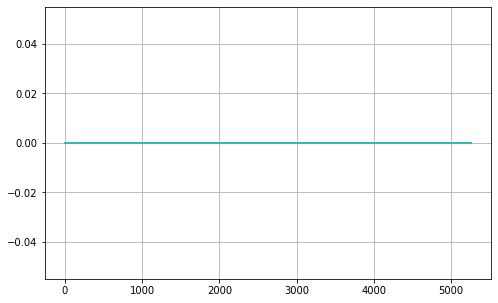

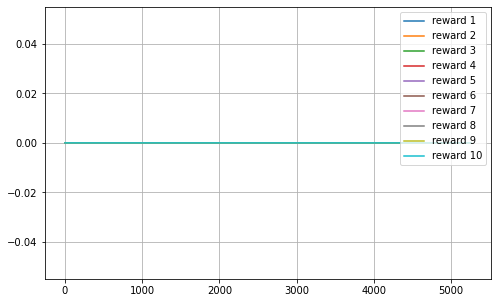

In [66]:
#profit and rewards
N = num
plt.figure(figsize = [8, 5])
for i in range(N):
    plt.plot(profit[i,:])
plt.grid(True)
#plt.legend(['profit '+str(i+1) for i in range(N)])
plt.show()


plt.figure(figsize = [8, 5])
for i in range(N):
    plt.plot(reward[i,:]>0)
plt.legend(['reward '+str(i+1) for i in range(N)])
plt.grid(True)
plt.show()


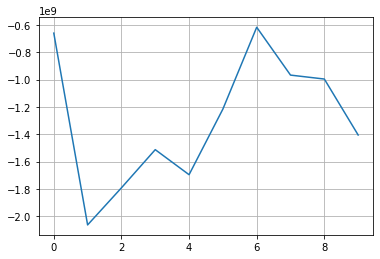

In [67]:
plt.plot(reward.sum(axis=1))
plt.grid(True)

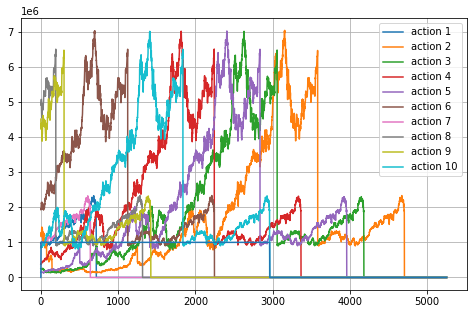

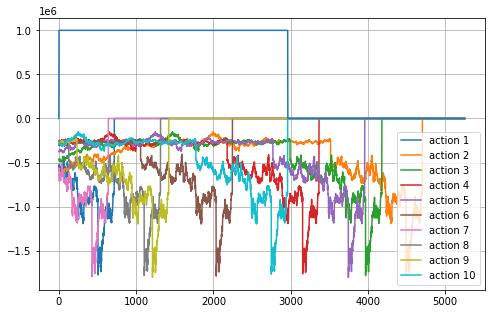

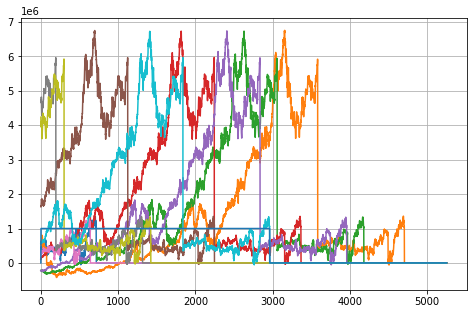

In [68]:
#ACTION
plt.figure(figsize = [8, 5])
for i in range(N):
    plt.plot(action[i,:,0])
#    plt.plot(action[i,:,1])
plt.plot(balance[N-1,:])
#plt.ylim(0,balance[N-1,0]+1900)
plt.legend(['action '+str(i+1) for i in range(N)])
plt.grid(True)
plt.show()

plt.figure(figsize = [8, 5])
for i in range(N):
#    plt.plot(action[-i,:,0])
    plt.plot(action[i,:,1])
plt.plot(balance[N-1,:])
#plt.ylim(0,balance[N-1,0]+1900)
plt.legend(['action '+str(i+1) for i in range(N)])
plt.grid(True)
plt.show()

plt.figure(figsize = [8, 5])
for i in range(N):
    plt.plot(action[i,:,0]+action[i,:,1])
plt.plot(balance[N-1,:])
#plt.ylim(0,balance[N-1,0]+1900)
plt.grid(True)
plt.show()

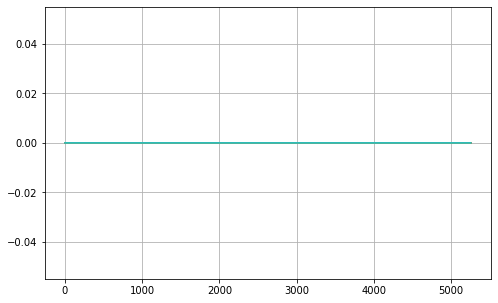

In [69]:
#shares
plt.figure(figsize = [8,5])
for i in range(N):
    plt.plot(shares[i,:,0])
    plt.plot(shares[i,:,1])
#plt.legend(['shares '+str(i+1) for i in range(2*N)])

plt.grid(True)
plt.show()

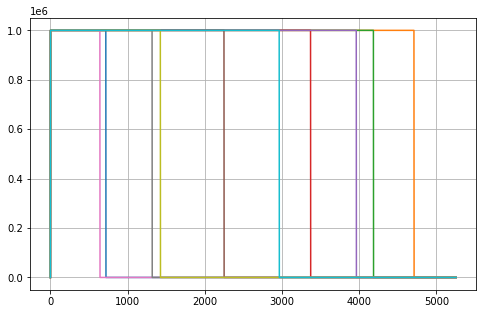

In [70]:
#Balance
plt.figure(figsize = [8, 5])
for i in range(N):
    plt.plot(balance[i,:])
#plt.legend(['balance '+str(i+1) for i in range(N)])

plt.grid(True)
plt.show()

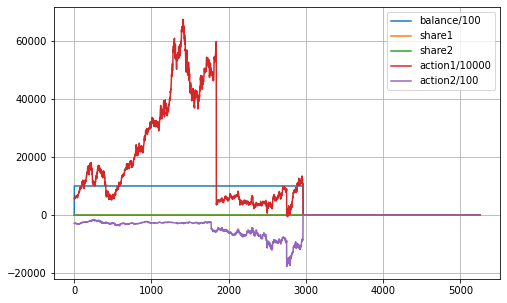

In [71]:
#last iteration
plt.figure(figsize = [8, 5])
plt.plot(balance[-1,:]/100)
plt.plot(shares[-1,:,0])
plt.plot(shares[-1,:,1])
plt.plot((action[-1,:,1]+action[-1,:,0])/100)
plt.plot(action[-1,:,1]/100)
#plt.plot(profit[N-1,:])
#plt.plot(r[N-1])
plt.grid(True)
plt.legend(['balance/100', 'share1', 'share2', 'action1/10000', 'action2/100', 'profit', 'reward'])

plt.show()